## Imports

In [ ]:
import optax
import imageio
import numpy as np
import functools
import jax
import jax.numpy as jnp
import flax.linen as nn
import matplotlib.pyplot as plt

from jax import random
from jax.experimental import ode
from flax.training import train_state
from sklearn.datasets import make_moons
from scipy.integrate import solve_ivp
from matplotlib.animation import FuncAnimation

## Swish Activation

In [ ]:
class Swish(nn.Module):

  @nn.compact
  def __call__(self, x):
    return x * jax.nn.sigmoid(x)

## Vector Field Model


In [ ]:
class MLP(nn.Module):
  input_dim: int
  time_dim: int
  hidden_dim: int

  @nn.compact
  def __call__(self, x, t):
    size = x.shape
    h = jnp.concatenate([x, t], axis = -1)
    h = nn.Dense(self.hidden_dim)(h)
    h = Swish()(h)
    h = nn.Dense(self.hidden_dim)(h)
    h = Swish()(h)
    h = nn.Dense(self.hidden_dim)(h)
    h = Swish()(h)
    h = nn.Dense(self.input_dim)(h)
    return h.reshape(*size)


## Make Dataset

In [ ]:
def make_dataset(num_samples):
  X, _ = make_moons(n_samples = num_samples, noise = 0.01, random_state = 42)
  return np.array(X, dtype = np.float32)


## Update Step

In [ ]:
@jax.jit
def update(state, x_t, t, dx_t):

  def loss_fn(params):
    vector_field = state.apply_fn({"params": params}, x_t, t)
    loss = jnp.mean((vector_field - dx_t) ** 2)
    return loss

  grad_fn = jax.value_and_grad(loss_fn)
  loss, grad = grad_fn(state.params)
  return state.apply_gradients(grads = grad), loss


## Initialize State

In [ ]:
def create_train_state(rng, model, input_shape, time_shape):
  @jax.jit
  def initialize_model(rng):
    return model.init(rng, jnp.ones(input_shape, dtype=jnp.float32), jnp.ones(time_shape, dtype=jnp.float32))["params"]

  params = initialize_model(rng)
  tx = optax.adamw(learning_rate = 1e-3)

  return train_state.TrainState.create(
      apply_fn = model.apply,
      params = params,
      tx = tx
  )

## Sample

In [ ]:
def sample(apply_fn, params, num_samples, data_dim):
  all_samples = []
  timesteps = 100
  samples = random.normal(random.PRNGKey(1), (num_samples, data_dim))
  all_samples.append(samples)
  dt = 1 / timesteps
  for t in jnp.linspace(0.0, 1.0, timesteps):
    time = jnp.ones((num_samples, 1)) * t
    v_t = apply_fn({"params": params}, samples, time)
    samples += v_t * dt
    all_samples.append(samples)
  return np.stack(all_samples, axis = 0)

## Plot and Save Samples

In [ ]:
def plot_and_save(data_x, data_y, title, filename, show = False):
  plt.figure()
  plt.scatter(data_x, data_y)
  plt.title(title)
  plt.savefig(filename)
  if show:
    plt.show()
  else:
    plt.close()
  return filename

## Train and Generate

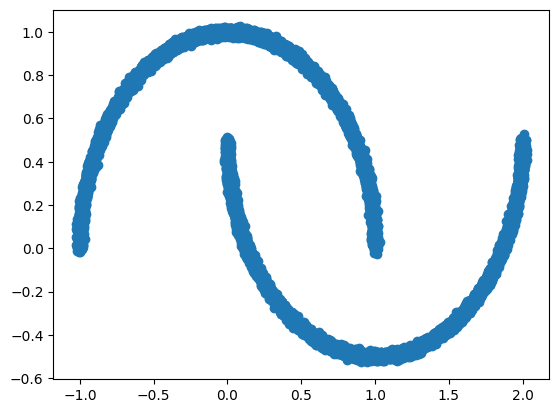

Step 0 | 10000: Loss - 1.6323035955429077
Step 500 | 10000: Loss - 0.9586871862411499
Step 1000 | 10000: Loss - 0.9478126168251038
Step 1500 | 10000: Loss - 0.9202367067337036
Step 2000 | 10000: Loss - 0.925064206123352
Step 2500 | 10000: Loss - 0.8912145495414734
Step 3000 | 10000: Loss - 0.9323479533195496
Step 3500 | 10000: Loss - 0.9389286637306213
Step 4000 | 10000: Loss - 0.9413780570030212
Step 4500 | 10000: Loss - 0.9068560600280762
Step 5000 | 10000: Loss - 0.896051824092865
Step 5500 | 10000: Loss - 0.9088929891586304
Step 6000 | 10000: Loss - 0.8974801898002625
Step 6500 | 10000: Loss - 0.9034873247146606
Step 7000 | 10000: Loss - 0.9050964713096619
Step 7500 | 10000: Loss - 0.9463473558425903
Step 8000 | 10000: Loss - 0.9138850569725037
Step 8500 | 10000: Loss - 0.948226273059845
Step 9000 | 10000: Loss - 0.9022427201271057
Step 9500 | 10000: Loss - 0.8917209506034851


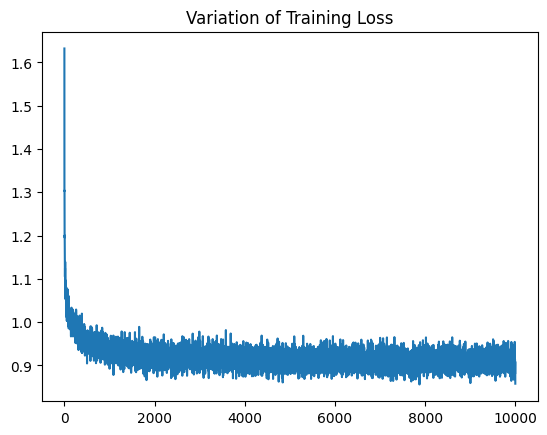

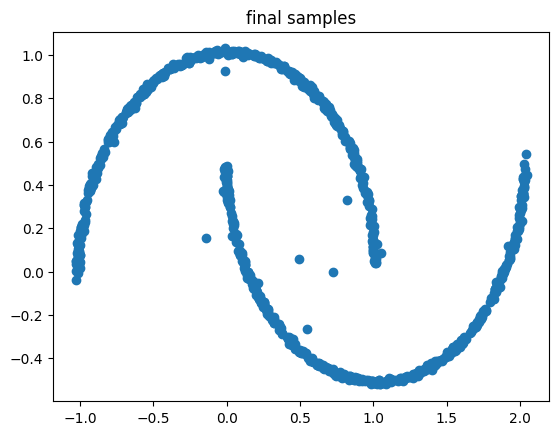

In [29]:
def main():
  batch_size = 4096
  iterations = 10000
  hidden_dim = 512
  key = 42
  num_samples = 20000
  eval_samples = 1000
  eval_interval = 500
  batch_counter = 0

  dataset = make_dataset(num_samples)
  plt.figure()
  plt.scatter(dataset[:,0], dataset[:,-1])
  plt.show()

  data_dim = dataset.shape[-1]
  model = MLP(input_dim = data_dim, time_dim = 1, hidden_dim = hidden_dim)
  rng = random.PRNGKey(key)
  rng, init_rng = jax.random.split(rng)
  state = create_train_state(
      init_rng,
      model,
      input_shape = (batch_size, data_dim),
      time_shape = (batch_size, 1)
  )
  losses = []
  for step in range(iterations):
    min_size = batch_counter * batch_size
    max_size = (batch_counter + 1) * batch_size
    if max_size > num_samples:
      max_size = -1
      batch_counter = 0
    x_1 = dataset[min_size:max_size]
    rng, sub_rng = random.split(rng)
    x_0 = random.normal(rng, (batch_size, data_dim))
    t = random.uniform(sub_rng, (batch_size, 1))
    x_t = (1 - t) * x_0 + t * x_1
    dx_t = x_1 - x_0

    state, loss = update(state, x_t, t, dx_t)
    losses.append(loss)
    if step % eval_interval == 0:
      print(f"Step {step} | {iterations}: Loss - {loss}")

  plt.figure()
  plt.plot([i for i in range(0, len(losses))], losses)
  plt.title("Variation of Training Loss")
  plt.show()

  eval_samples = sample(state.apply_fn, state.params, eval_samples, data_dim)
    # plt.scatter(eval_samples[-1,:,0], eval_samples[-1,:,1])
  plot_and_save(eval_samples[-1,:,0], eval_samples[-1,:,1], "final samples", "final_samples", show = True)
  filenames = []
  for i in range(len(eval_samples)):
    filename = plot_and_save(eval_samples[i,:,0], eval_samples[i,:,1], f"samples at step {i}", f"step_{i}.png")
    filenames.append(filename)
  frames = [imageio.v2.imread(filename) for filename in filenames]
  imageio.mimsave("samples.gif", frames, fps = 5)




if __name__ == "__main__":
  main()


## Display Sampling Process

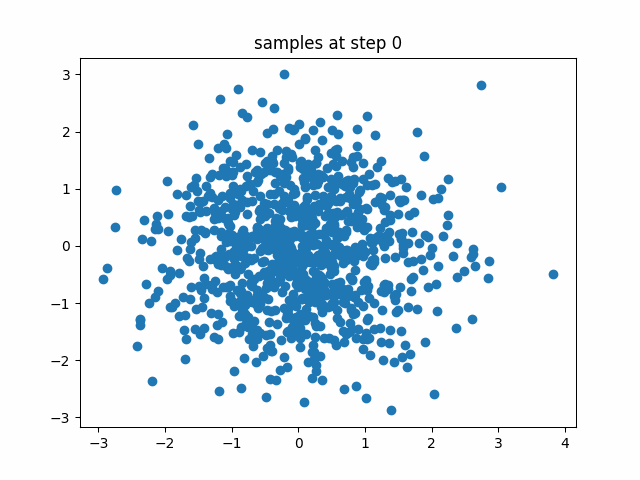

In [35]:
from IPython.display import Image

file_path = '/content/samples.gif'
Image(filename=file_path,embed=True)